In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
from helpers import read_hdf5, CombineDataset
from lenshelpers import Residual

from model.helpers_model import NeuralNet

import warnings
warnings.filterwarnings('ignore') 

from sklearn.metrics import precision_recall_curve, f1_score, auc, accuracy_score, roc_curve, roc_auc_score

In [2]:
# Build the four classes 
config_repo_model = 'data/configFile/config_model'
ratio = 0.5
percent = 0.01

size = 3000
for i in np.arange(1,4):
    res = Residual()
    res.build(size, i, ratio = ratio, per_error = percent)

print('Data Generation Finished')

Data Generation Finished


In [3]:
metadata = pd.DataFrame()

for i in np.arange(1,4):
    str_ID = "E"+str(i)+"P"+str(int(percent*100))+"R"+str(int(ratio*100))
    [img, meta] = read_hdf5(str_ID, path = "data/dataSet/")
    metadata = pd.concat([metadata,meta], ignore_index=True)
    if i == 1:
        final_array = img
    else:
         final_array = np.concatenate((final_array, img))
metadata ['ID'] = np.arange(0,final_array.shape[0])
data_set = CombineDataset(metadata,'ID','class',final_array)

print('Reading Data Finished')
data_train, data_test = train_test_split(data_set,train_size=0.9,random_state=42)

batch_size = 50
max_epoch = 70


loader_train = DataLoader(data_train, batch_size = batch_size, shuffle = True, 
                          num_workers = 0, drop_last=True)

loader_test = DataLoader(data_test, batch_size = batch_size, shuffle = True, 
                         num_workers = 0, drop_last=True)

Reading Data Finished


In [19]:
metric = 'hamming'
netacc = NeuralNet('BasicCNN', 'SGD/momentum')
for epoch in range(max_epoch):
    netacc.train(loader_train)
    res = netacc.test(loader_test,epoch, metric = metric)
    
print('Finished Training')
epoch = netacc.load_checkpoint()

with torch.no_grad():
    predictions = []
    targets = []
    for data in loader_test:
        images, meta, labels = data
        outputs = netacc.net(images)

        predictions.extend(outputs.cpu().numpy())
        targets.extend(labels.cpu().numpy())
        result = netacc.calculate_metrics(np.round(np.array(predictions)), np.array(targets))

epoch: 0.000, hamming: 0.327
epoch: 2.000, hamming: 0.328
Finished Training


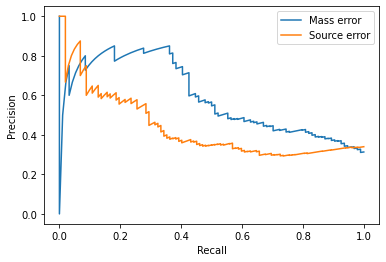

In [20]:
# calculate precision-recall curve
precision0, recall0, thresholds0 = precision_recall_curve(np.array(targets)[:,0], np.array(predictions)[:,0])
precision1, recall1, thresholds1 = precision_recall_curve(np.array(targets)[:,1], np.array(predictions)[:,1])

plt.plot(recall0, precision0, label='Mass error')
plt.plot(recall1, precision1, label='Source error')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot

plt.savefig('figures/metric/'+metric+'RecallPrecision.jpeg')
plt.show()

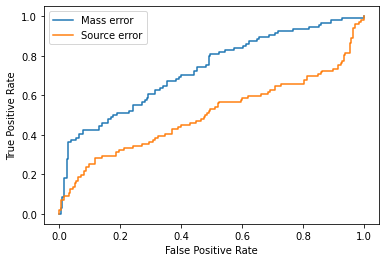

AUC score: 0.499, with hamming metric


In [21]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(np.array(targets)[:,0], np.array(predictions)[:,0])
lr_fpr, lr_tpr, _ = roc_curve(np.array(targets)[:,1], np.array(predictions)[:,1])
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, label='Mass error')
plt.plot(lr_fpr, lr_tpr, label='Source error')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.savefig('figures/metric/'+metric+'ROC.jpeg')
plt.show()

txt = "AUC score: {:.3f}, with "+metric+" metric" 
print(txt.format(result['auc']))